In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

df = pd.read_csv('../click_fraud_dataset.csv')
df.head()

,click_id,timestamp,user_id,ip_address,device_type,browser,operating_system,referrer_url,page_url,click_duration,...,mouse_movement,keystrokes_detected,ad_position,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,bot_likelihood_score,is_fraudulent
0,d875835d-3a4a-4a20-b0d1-6cddf89afc6a,2024-08-23 02:47:39,65a2f621-707b-49be-9c3e-ccac0b1d89ef,141.36.49.37,Tablet,Safari,Android,https://evans-ford.com/,http://www.turner-stewart.com/,0.29,...,111,8,Bottom,7,72,Good,0,1,0.29,0
1,a2d3f028-7790-4be1-9f75-df1357edbbdb,2025-01-30 23:23:50,135e0114-76c5-43ea-bdef-80ab537dc009,216.29.19.201,Desktop,Opera,iOS,https://pierce-ferguson.net/,http://www.rodriguez.biz/,0.64,...,452,29,Bottom,9,201,Suspicious,0,0,0.74,0
2,36d787b2-fbce-43ef-8c02-7c8746d7e3db,2025-01-21 05:41:12,a6922984-78cb-4c01-9c88-bfe3a13a0aaf,167.133.41.231,Tablet,Safari,Linux,https://www.martinez.com/,https://beck.biz/,0.42,...,431,18,Bottom,9,326,Good,0,1,0.14,0
3,01fc0078-096b-4f90-82ae-aa8085b719ac,2024-10-12 08:18:14,d30788b2-4048-4770-a4b1-a9358788818f,216.146.33.78,Tablet,Edge,macOS,https://jones-mendoza.com/,https://www.alvarado.com/,4.29,...,472,37,Side,4,33,Suspicious,0,0,0.65,0
4,0afdf2af-0b48-47d5-bfb6-e087053e1eb9,2024-04-19 14:44:35,dfc42287-6325-4344-b373-b8e61ea6e5c1,146.37.54.245,Desktop,Opera,Windows,https://www.griffith-holloway.com/,http://gonzalez.com/,2.46,...,50,2,Side,7,97,Good,0,0,0.06,0


Drop irrelevant columns

In [43]:
# Remove IDs, timestamps, and URLs (not useful for training)
drop_cols = [
    'click_id', 'timestamp', 'user_id', 'referrer_url', 'page_url', 'ad_position', 'bot_likelihood_score'
]
df = df.drop(columns=drop_cols)
df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,Good,0,1,0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,Suspicious,0,0,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,Good,0,1,0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,Suspicious,0,0,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,Good,0,0,0


In [44]:
import geoip2.database

city_db = "GeoLite2/GeoLite2-City.mmdb"
asn_db = "GeoLite2/GeoLite2-ASN.mmdb"

reader_city = geoip2.database.Reader(city_db)
reader_asn = geoip2.database.Reader(asn_db)

def enrich_ip(ip):
    data = {
        "ip_country": None,
        "ip_city": None,
        "ip_asn": None,
        "ip_org": None,
        "ip_is_datacenter": 0
    }
    try:
        city = reader_city.city(ip)
        asn = reader_asn.asn(ip)

        data["ip_country"] = city.country.name
        data["ip_city"] = city.city.name
        data["ip_asn"] = asn.autonomous_system_number
        data["ip_org"] = asn.autonomous_system_organization

        # crude datacenter detection
        dc_keywords = ['Amazon', 'Google', 'OVH', 'Microsoft', 'DigitalOcean', 'Hetzner', 'Linode']
        if any(k in (asn.autonomous_system_organization or "") for k in dc_keywords):
            data["ip_is_datacenter"] = 1
    except Exception:
        pass
    return pd.Series(data)

# Example use:
ip_info = enrich_ip("203.94.72.111")
print(ip_info)


ip_country                           Sri Lanka
ip_city                                Colombo
ip_asn                                    9329
ip_org              Sri Lanka Telecom Internet
ip_is_datacenter                             0
dtype: object


In [45]:
df = df.join(df['ip_address'].apply(enrich_ip))
df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,Good,0,1,0,NaN,NaN,NaN,NaN,0.0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,Suspicious,0,0,0,United States,None,174.0,COGENT-174,0.0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,Good,0,1,0,NaN,NaN,NaN,NaN,0.0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,Suspicious,0,0,0,United States,Ashburn,31898.0,ORACLE-BMC-31898,0.0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,Good,0,0,0,NaN,NaN,NaN,NaN,0.0


In [46]:
from user_agents import parse

def parse_user_agent(ua_str):
    try:
        ua = parse(ua_str)
        return pd.Series({
            "ua_browser": ua.browser.family,
            "ua_os": ua.os.family,
            "ua_device": ua.device.family,
            "ua_is_mobile": ua.is_mobile,
            "ua_is_tablet": ua.is_tablet,
            "ua_is_pc": ua.is_pc,
            "ua_is_bot": ua.is_bot
        })
    except Exception:
        return pd.Series({
            "ua_browser": None,
            "ua_os": None,
            "ua_device": None,
            "ua_is_mobile": False,
            "ua_is_tablet": False,
            "ua_is_pc": False,
            "ua_is_bot": False
        })

# Example:
ua_info = parse_user_agent("Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/117.0.0.0 Safari/537.36")
print(ua_info)


ua_browser       Chrome
ua_os           Windows
ua_device         Other
ua_is_mobile      False
ua_is_tablet      False
ua_is_pc           True
ua_is_bot         False
dtype: object


In [47]:
import ipaddress

def is_private_ip(ip):
    try:
        return ipaddress.ip_address(ip).is_private
    except:
        return False

def fraud_score(row):
    score = 0

    # 1️ IP-based
    if row.get("ip_is_datacenter") == 1:
        score += 3
    if is_private_ip(row.get("ip_address", "")):
        score += 2
    if row.get("VPN_usage") == 1 or row.get("proxy_usage") == 1:
        score += 2

    # 2️ Device & OS mismatch
    os = str(row.get("operating_system", "")).lower()
    browser = str(row.get("browser", "")).lower()
    device = str(row.get("device_type", "")).lower()

    if "windows" in os and "safari" in browser:
        score += 2
    if device == "mobile" and row.get("mouse_movement", 0) > 0:
        score += 1

    # 3️ User-agent analysis (if parsed)
    if row.get("ua_is_bot", False):
        score += 4

    # 4️ Behavior
    if row.get("click_duration", 10) < 1.0:
        score += 1

    return score

# Apply to dataset
df["fraud_score"] = df.apply(fraud_score, axis=1)

# Decide labels
df["predicted_label"] = (df["fraud_score"] >= 4).astype(int)  # 1=fraudulent, 0=genuine

df[["ip_address", "ip_country", "device_type", "browser", "operating_system", "fraud_score", "predicted_label"]].head()


,ip_address,ip_country,device_type,browser,operating_system,fraud_score,predicted_label
0,141.36.49.37,NaN,Tablet,Safari,Android,3,0
1,216.29.19.201,United States,Desktop,Opera,iOS,1,0
2,167.133.41.231,NaN,Tablet,Safari,Linux,3,0
3,216.146.33.78,United States,Tablet,Edge,macOS,0,0
4,146.37.54.245,NaN,Desktop,Opera,Windows,0,0


In [48]:
# Convert all ASN values to string and fill NaN with "Unknown"
df["ip_asn"] = df["ip_asn"].astype(str).fillna("Unknown")

# Optional: Clean numeric-only ASNs (make them consistent like 'AS12345')
df["ip_asn"] = df["ip_asn"].apply(lambda x: f"AS{x}" if x.isdigit() else x)
df.head()


,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label
0,141.36.49.37,Tablet,Safari,Android,0.29,60,111,8,7,72,...,0,1,0,NaN,NaN,nan,NaN,0.0,3,0
1,216.29.19.201,Desktop,Opera,iOS,0.64,25,452,29,9,201,...,0,0,0,United States,None,174.0,COGENT-174,0.0,1,0
2,167.133.41.231,Tablet,Safari,Linux,0.42,36,431,18,9,326,...,0,1,0,NaN,NaN,nan,NaN,0.0,3,0
3,216.146.33.78,Tablet,Edge,macOS,4.29,29,472,37,4,33,...,0,0,0,United States,Ashburn,31898.0,ORACLE-BMC-31898,0.0,0,0
4,146.37.54.245,Desktop,Opera,Windows,2.46,94,50,2,7,97,...,0,0,0,NaN,NaN,nan,NaN,0.0,0,0


Encode categorical features

In [49]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical columns
label_encoders = {}
for col in ["device_type", "browser", "operating_system", "device_ip_reputation", "ip_country", "ip_city", "ip_asn", "ip_org"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()

,ip_address,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,...,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label
0,141.36.49.37,2,4,0,0.29,60,111,8,7,72,...,0,1,0,122,1417,1227,1147,0.0,3,0
1,216.29.19.201,0,3,3,0.64,25,452,29,9,201,...,0,0,0,117,1416,251,179,0.0,1,0
2,167.133.41.231,2,4,1,0.42,36,431,18,9,326,...,0,1,0,122,1417,1227,1147,0.0,3,0
3,216.146.33.78,2,1,4,4.29,29,472,37,4,33,...,0,0,0,117,61,615,689,0.0,0,0
4,146.37.54.245,0,3,2,2.46,94,50,2,7,97,...,0,0,0,122,1417,1227,1147,0.0,0,0


In [50]:
# Drop ip_address after enrichment
df = df.drop(columns=['ip_address'])
df.head()

,device_type,browser,operating_system,click_duration,scroll_depth,mouse_movement,keystrokes_detected,click_frequency,time_since_last_click,device_ip_reputation,VPN_usage,proxy_usage,is_fraudulent,ip_country,ip_city,ip_asn,ip_org,ip_is_datacenter,fraud_score,predicted_label
0,2,4,0,0.29,60,111,8,7,72,1,0,1,0,122,1417,1227,1147,0.0,3,0
1,0,3,3,0.64,25,452,29,9,201,2,0,0,0,117,1416,251,179,0.0,1,0
2,2,4,1,0.42,36,431,18,9,326,1,0,1,0,122,1417,1227,1147,0.0,3,0
3,2,1,4,4.29,29,472,37,4,33,2,0,0,0,117,61,615,689,0.0,0,0
4,0,3,2,2.46,94,50,2,7,97,1,0,0,0,122,1417,1227,1147,0.0,0,0


Scale numerical features

In [51]:
from sklearn.preprocessing import StandardScaler

# Define numeric columns
numeric_cols = ['click_duration',
                'scroll_depth',
                'mouse_movement',
                'keystrokes_detected',
                'click_frequency',
                'time_since_last_click',
                'device_ip_reputation',
                'device_type',
                'browser',
                'operating_system',
                'ip_country',
                'ip_city',
                'ip_asn',
                'ip_org',
                'VPN_usage',
                'proxy_usage',
                'ip_is_datacenter',
                'fraud_score']

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("Scaling completed!")


Scaling completed!


Split into Features (X) and Target (y) and divide dataset

In [52]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["is_fraudulent", "predicted_label"])
y = df["is_fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Data ready for model training!")
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Data ready for model training!
Train size: (4000, 18)
Test size: (1000, 18)


In [53]:
y_train.value_counts()

is_fraudulent
0    3007
1     993
Name: count, dtype: int64

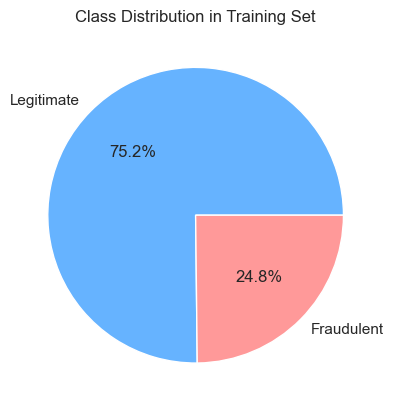

In [54]:
plt.pie(y_train.value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Class Distribution in Training Set')
plt.show()

### Handle Imbalanced Dataset

In [55]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE but do NOT apply it globally. We'll apply SMOTE inside cross-validation and training pipelines (best practice).
smote = SMOTE()
print('SMOTE instantiated. It will be applied inside pipelines during fitting.')
print('Train set shape:', X_train.shape, y_train.shape)

SMOTE instantiated. It will be applied inside pipelines during fitting.
Train set shape: (4000, 18) (4000,)


In [59]:
# Show training class distribution (original, SMOTE will be applied inside pipelines)
print(y_train.value_counts())

is_fraudulent
0    3007
1     993
Name: count, dtype: int64


### Supervised Model Training and Evaluation

In [60]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

Evaluation Function

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    prec = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores:\n\tAccuracy: {acc}\n\tPrecision: {prec}\n\tRecall: {rec}\n\tF1-Score: {f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    prec = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores:\n\tAccuracy: {acc}\n\tPrecision: {prec}\n\tRecall: {rec}\n\tF1-Score: {f1}')

# --- Cross-validation utility ---
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

def evaluate_cv(estimator, X, y, cv=5, smote=None):
    """Run stratified k-fold cross-validation and print mean±std for metrics.

    SMOTE is applied inside each training fold via an imblearn Pipeline, which prevents data leakage.
    """
    scoring = ['accuracy', 'precision', 'recall', 'f1']

    if smote is None:
        smote = SMOTE()

    # Wrap estimator into a pipeline that applies SMOTE on the training fold only
    pipeline = ImbPipeline([('smote', smote), ('clf', estimator)])

    cv_results = cross_validate(pipeline, X, y,
                                cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
                                scoring=scoring, n_jobs=-1, return_train_score=False)

    summary = {}
    for metric in scoring:
        key = f'test_{metric}'
        scores = cv_results[key]
        summary[metric] = (np.mean(scores), np.std(scores))
        print(f'CV {metric.capitalize()}: {summary[metric][0]:.3f} ± {summary[metric][1]:.3f}')

    return cv_results


#### Logistic Regression

In [62]:
from imblearn.pipeline import Pipeline as ImbPipeline

lr = LogisticRegression()
# Evaluate with cross-validation before full fit (SMOTE applied inside CV)
print('--- Logistic Regression CV ---')
evaluate_cv(lr, X_train, y_train, cv=5, smote=smote)

# Fit pipeline on full training set (SMOTE applied during fit)
lr_pipe = ImbPipeline([('smote', smote), ('clf', lr)])
lr_pipe.fit(X_train, y_train)

# Predictions
y_train_pred = lr_pipe.predict(X_train)

y_test_pred = lr_pipe.predict(X_test)

training_scores(y_train, y_train_pred)

validation_scores(y_test, y_test_pred)

--- Logistic Regression CV ---
CV Accuracy: 0.497 ± 0.013
CV Precision: 0.233 ± 0.012
CV Recall: 0.450 ± 0.035
CV F1: 0.307 ± 0.018
Training Scores:
	Accuracy: 0.522
	Precision: 0.266
	Recall: 0.529
	F1-Score: 0.354
Testing Scores:
	Accuracy: 0.484
	Precision: 0.235
	Recall: 0.48
	F1-Score: 0.316
CV Accuracy: 0.497 ± 0.013
CV Precision: 0.233 ± 0.012
CV Recall: 0.450 ± 0.035
CV F1: 0.307 ± 0.018
Training Scores:
	Accuracy: 0.522
	Precision: 0.266
	Recall: 0.529
	F1-Score: 0.354
Testing Scores:
	Accuracy: 0.484
	Precision: 0.235
	Recall: 0.48
	F1-Score: 0.316


#### Decision Tree

In [63]:
from imblearn.pipeline import Pipeline as ImbPipeline

dt = DecisionTreeClassifier()
print('--- Decision Tree CV ---')
evaluate_cv(dt, X_train, y_train, cv=5, smote=smote)

# Fit pipeline on full training set
dt_pipe = ImbPipeline([('smote', smote), ('clf', dt)])
dt_pipe.fit(X_train, y_train)

# Predictions
y_train_pred = dt_pipe.predict(X_train)

y_test_pred = dt_pipe.predict(X_test)

training_scores(y_train, y_train_pred)

validation_scores(y_test, y_test_pred)

--- Decision Tree CV ---
CV Accuracy: 0.594 ± 0.023
CV Precision: 0.240 ± 0.032
CV Recall: 0.292 ± 0.040
CV F1: 0.263 ± 0.035
Training Scores:
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0
Testing Scores:
	Accuracy: 0.609
	Precision: 0.251
	Recall: 0.29
	F1-Score: 0.269
CV Accuracy: 0.594 ± 0.023
CV Precision: 0.240 ± 0.032
CV Recall: 0.292 ± 0.040
CV F1: 0.263 ± 0.035
Training Scores:
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0
Testing Scores:
	Accuracy: 0.609
	Precision: 0.251
	Recall: 0.29
	F1-Score: 0.269


#### Random Forest

In [64]:
from imblearn.pipeline import Pipeline as ImbPipeline

rf = RandomForestClassifier()
print('--- Random Forest CV ---')
evaluate_cv(rf, X_train, y_train, cv=5, smote=smote)

rf_pipe = ImbPipeline([('smote', smote), ('clf', rf)])
rf_pipe.fit(X_train, y_train)

# Predictions
y_train_pred = rf_pipe.predict(X_train)

y_test_pred = rf_pipe.predict(X_test)

training_scores(y_train, y_train_pred)

validation_scores(y_test, y_test_pred)

--- Random Forest CV ---
CV Accuracy: 0.730 ± 0.007
CV Precision: 0.262 ± 0.102
CV Recall: 0.051 ± 0.022
CV F1: 0.086 ± 0.035
CV Accuracy: 0.730 ± 0.007
CV Precision: 0.262 ± 0.102
CV Recall: 0.051 ± 0.022
CV F1: 0.086 ± 0.035
Training Scores:
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0
Testing Scores:
	Accuracy: 0.723
	Precision: 0.204
	Recall: 0.04
	F1-Score: 0.067
Training Scores:
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0
Testing Scores:
	Accuracy: 0.723
	Precision: 0.204
	Recall: 0.04
	F1-Score: 0.067


#### SVM

In [65]:
from imblearn.pipeline import Pipeline as ImbPipeline

svc = SVC()
# Note: SVC CV can be slow on large datasets. Consider using a linear/kernel approximation or fewer folds if needed.
print('--- SVC CV ---')
evaluate_cv(svc, X_train, y_train, cv=5, smote=smote)

svc_pipe = ImbPipeline([('smote', smote), ('clf', svc)])
svc_pipe.fit(X_train, y_train)

# Predictions
y_train_pred = svc_pipe.predict(X_train)

y_test_pred = svc_pipe.predict(X_test)

training_scores(y_train, y_train_pred)

validation_scores(y_test, y_test_pred)

--- SVC CV ---
CV Accuracy: 0.579 ± 0.016
CV Precision: 0.239 ± 0.023
CV Recall: 0.317 ± 0.035
CV F1: 0.272 ± 0.027
CV Accuracy: 0.579 ± 0.016
CV Precision: 0.239 ± 0.023
CV Recall: 0.317 ± 0.035
CV F1: 0.272 ± 0.027
Training Scores:
	Accuracy: 0.737
	Precision: 0.479
	Recall: 0.68
	F1-Score: 0.562
Testing Scores:
	Accuracy: 0.558
	Precision: 0.228
	Recall: 0.327
	F1-Score: 0.268
Training Scores:
	Accuracy: 0.737
	Precision: 0.479
	Recall: 0.68
	F1-Score: 0.562
Testing Scores:
	Accuracy: 0.558
	Precision: 0.228
	Recall: 0.327
	F1-Score: 0.268


#### XGBoost

In [66]:
from imblearn.pipeline import Pipeline as ImbPipeline

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
print('--- XGBoost CV ---')
evaluate_cv(xgb, X_train, y_train, cv=5, smote=smote)

xgb_pipe = ImbPipeline([('smote', smote), ('clf', xgb)])
xgb_pipe.fit(X_train, y_train)

# Predictions
y_train_pred = xgb_pipe.predict(X_train)

y_test_pred = xgb_pipe.predict(X_test)

training_scores(y_train, y_train_pred)

validation_scores(y_test, y_test_pred)

--- XGBoost CV ---
CV Accuracy: 0.697 ± 0.005
CV Precision: 0.244 ± 0.021
CV Recall: 0.105 ± 0.008
CV F1: 0.147 ± 0.011
Training Scores:
	Accuracy: 0.991
	Precision: 1.0
	Recall: 0.964
	F1-Score: 0.982
Testing Scores:
	Accuracy: 0.719
	Precision: 0.319
	Recall: 0.117
	F1-Score: 0.171
CV Accuracy: 0.697 ± 0.005
CV Precision: 0.244 ± 0.021
CV Recall: 0.105 ± 0.008
CV F1: 0.147 ± 0.011
Training Scores:
	Accuracy: 0.991
	Precision: 1.0
	Recall: 0.964
	F1-Score: 0.982
Testing Scores:
	Accuracy: 0.719
	Precision: 0.319
	Recall: 0.117
	F1-Score: 0.171


### Hyperparameter Optimization

GridSearchCV for XGBoost

In [67]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# Define parameter grid for tuning (use 'clf__' prefix for pipeline's estimator)
param_grid = {
    'clf__n_estimators': [100, 200, 300],   # number of boosting rounds
    'clf__max_depth': [3, 5, 7],            # tree depth
    'clf__learning_rate': [0.01, 0.1, 0.2], # step size shrinkage
    'clf__subsample': [0.7, 0.8, 1.0],      # fraction of samples used per tree
    'clf__colsample_bytree': [0.7, 0.8, 1.0],# fraction of features per tree
    'clf__min_child_weight': [1, 3]
}

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Baseline CV for default XGB before grid search
print('--- Baseline XGBoost CV (before GridSearch) ---')
evaluate_cv(xgb, X_train, y_train, cv=3, smote=smote)

# Build pipeline for GridSearch (SMOTE + classifier)
pipeline = ImbPipeline([('smote', smote), ('clf', xgb)])

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',   # You can also use 'accuracy', 'precision', 'recall'
    cv=3,
    verbose=1,
    n_jobs=-1,
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Use best estimator
best_xgb = grid_search.best_estimator_

# Predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Evaluate
training_scores(y_train, y_train_pred)
validation_scores(y_test, y_test_pred)

--- Baseline XGBoost CV (before GridSearch) ---
CV Accuracy: 0.697 ± 0.005
CV Precision: 0.233 ± 0.026
CV Recall: 0.096 ± 0.016
CV F1: 0.135 ± 0.020
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
CV Accuracy: 0.697 ± 0.005
CV Precision: 0.233 ± 0.026
CV Recall: 0.096 ± 0.016
CV F1: 0.135 ± 0.020
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Training Scores:
	Accuracy: 0.681
	Precision: 0.305
	Recall: 0.221
	F1-Score: 0.256
Testing Scores:
	Accuracy: 0.659
	Precision: 0.24
	Recall: 0.173
	F1-Score: 0.201
Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Training Scores:
	Accuracy: 0.681
	Precision: 0.305
	Recall: 0.221
	F1-Score: 0.256
Testing Scores:
	Accurac

#### Save and Load XGBoost Model

In [68]:
# Save XGBoost Model
import pickle
with open('Ensemble_Model/Base_Models/xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

In [69]:
# Load XGBoost Model
with open('Ensemble_Model/Base_Models/xgb_model.pkl', 'rb') as f:
    loaded_xgb = pickle.load(f)

Sample Inputs

In [70]:
# --- Example Input ---
example_input = {
    "device_type": "Desktop",
    "browser": "Firefox",
    "operating_system": "Windows",
    "click_duration": 3.2,
    "scroll_depth": 60,
    "mouse_movement": 120,
    "keystrokes_detected": 40,
    "click_frequency": 7,
    "time_since_last_click": 72,
    "device_ip_reputation": "Good",
    "VPN_usage": 0,
    "proxy_usage": 1,
    "ip_country": "United States",
    "ip_city": "Los Angeles",
    "ip_asn": "AS15169",
    "ip_org": "Google LLC",
    "ip_is_datacenter": 0,
    "fraud_score": 3
}

example_df = pd.DataFrame([example_input])

In [71]:
# --- Clean and handle categorical features ---
categorical_cols = [
    "device_type", "browser", "operating_system",
    "device_ip_reputation", "ip_country", "ip_city",
    "ip_asn", "ip_org"
]

# Handle unseen labels gracefully
for col in categorical_cols:
    if "Unknown" not in label_encoders[col].classes_:
        label_encoders[col].classes_ = np.append(label_encoders[col].classes_, "Unknown")

    value = example_df[col].iloc[0]
    if value not in label_encoders[col].classes_:
        example_df[col] = ["Unknown"]
    example_df[col] = label_encoders[col].transform(example_df[col])

    print(f"Encoded {col}: {example_df[col].iloc[0]}")

Encoded device_type: 0
Encoded browser: 2
Encoded operating_system: 2
Encoded device_ip_reputation: 1
Encoded ip_country: 117
Encoded ip_city: 725
Encoded ip_asn: 1228
Encoded ip_org: 1148


In [72]:
# --- Identify numeric columns ---
numeric_cols = [
    "device_type", "browser", "operating_system",
    "click_duration", "scroll_depth", "mouse_movement",
    "keystrokes_detected", "click_frequency",
    "time_since_last_click", "device_ip_reputation",
    "VPN_usage", "proxy_usage",
    "ip_country", "ip_city", "ip_asn", "ip_org",
     "ip_is_datacenter", "fraud_score"
]

# --- Apply same scaler as training (DO NOT FIT AGAIN) ---
example_df[numeric_cols] = scaler.fit_transform(example_df[numeric_cols])

# Reorder columns to match training data
example_df = example_df[numeric_cols]

# --- Make prediction ---
prediction = loaded_xgb.predict(example_df)
print("✅ Prediction:", "Fraudulent" if prediction[0] == 1 else "Genuine")

✅ Prediction: Fraudulent
